In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
from jbolo_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]


# Analysis of Alternatives - Instrument sensitivities

In this notebook I calculate some of the sensitivity information needed for the AoA exercise.

SAT options: [DONE]
- See SAT_NETs_AoA_final.ipynb notebook.
 
BK: [DONE]
 - For use in the "scaling from achieved performance", run with Pole S4 baseline design assumptions, but change the cold stage temperature and the bands.
 
LATs:
- Run 20GHz on the CHLAT.  Rerun other channels on the CHLAT (we've been using a bolo_calc run result) so the ratio of 20GHz and 30GHz NETs can be made.
 
SO:  (lower priority)
 - Run SO design with S4-like assumptions where possible, for comparision with the Chile S4 designs.
 - This includes regular SO-MF bands, and changing those to S4's MF1 and MF2 bands
 
In all these calculations we use flat bandpass functions.

# CMB-S4 bands
Define the current band edges

In [5]:
# Read in yaml so we can have S4 band edge info
# in sim['channels'][ch]['nu_low'] and ['nu_high']
sim = yaml.safe_load(open('yamls/SAT_baseline_20220627.yaml'))

# BK bands
We need to find the flat-top band models to use with BK, based on their real bands.
We'll also plot them relative to the relevant CMB-S4 SAT and LAT bands.

In [6]:
pwd

'/Users/ruhl/code/bolo_calc_runs/jbolo/AoA'

BK bands:  Center  Width  Low_edge  high_edge
95 :        94.9    20.0    84.9   104.9
150 :       147.9    35.1   130.4   165.5
220 :       231.0    34.8   213.5   248.4


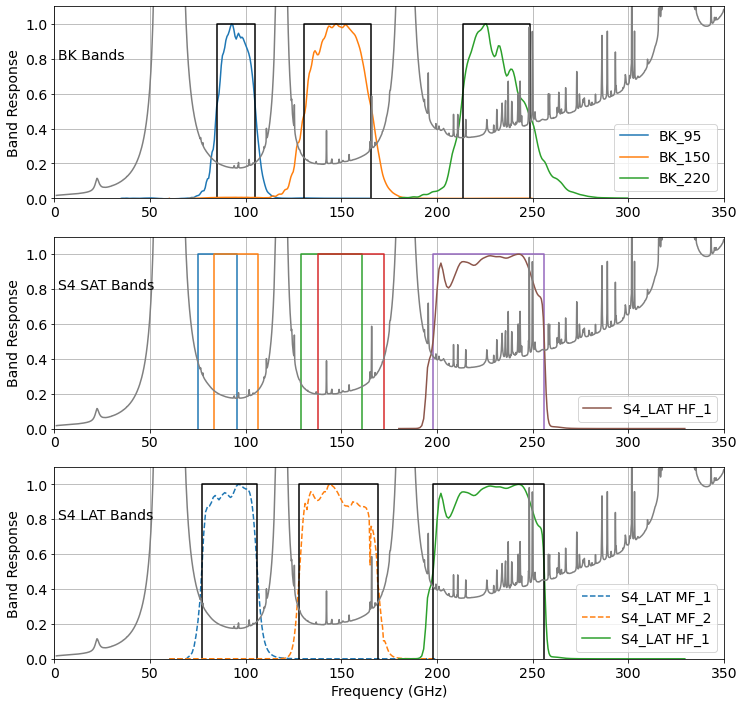

In [7]:
# Plot BK bands.  Use the RJ normalization because that is the "flat on transmission line" normalization, ie 
# what we use in jbolo.

plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 12]

BKbands = {'95':{}, '150':{}, '220':{}}
bandtype = 'b_rj' # or 'b_unif'

for band in BKbands.keys():
    filename = 'BK_bands/BK15_'+band+'_bandpass_20180920.txt'
    BKbands[band]['nu_ghz'], BKbands[band]['b_unif'], BKbands[band]['b_rj'] = np.loadtxt(filename,unpack=True)
    A = np.trapz(BKbands[band][bandtype]*BKbands[band]['nu_ghz'],BKbands[band]['nu_ghz'])
    B = np.trapz(BKbands[band][bandtype],BKbands[band]['nu_ghz'])
    BKbands[band]['center'] = A/B
    BKbands[band]['width']=B
    BKbands[band]['low_edge']=BKbands[band]['center'] - B/2
    BKbands[band]['high_edge']=BKbands[band]['center'] + B/2

plt.subplot(3,1,1)
print('BK bands:  Center  Width  Low_edge  high_edge')
for band in BKbands.keys():
    labelstr = 'BK_'+band
    plt.plot(BKbands[band]['nu_ghz'], BKbands[band]['b_rj'],label=labelstr)
    print(band,end=' :')
    print('      {0:6.1f}  {1:6.1f}  {2:6.1f}  {3:6.1f}'.format(BKbands[band]['center'],BKbands[band]['width'], BKbands[band]['low_edge'],BKbands[band]['high_edge']))
    xvals = [BKbands[band]['low_edge'], BKbands[band]['low_edge'], BKbands[band]['high_edge'], BKbands[band]['high_edge']]
    yvals = [0,1,1,0]
    plt.plot(xvals,yvals,'-k')
nu,Tb = np.loadtxt('Atacama_993u_50deg.txt',unpack=True)
plt.plot(nu,Tb/50,'gray')
plt.legend()
plt.xlim(0,350)
plt.ylim(0,1.1)
plt.text(2,0.8,'BK Bands')
plt.ylabel('Band Response')
plt.grid()

# Plot S4 SAT flat bands
plt.subplot(3,1,2)
plt.xlim(0,350)
plt.ylim(0,1.1)
chlist = ['MF_1_1','MF_1_2','MF_2_1','MF_2_2','HF_1']
for ch in sim['channels'].keys():
    nu_low = sim['channels'][ch]['nu_low']
    nu_high = sim['channels'][ch]['nu_high']
    if ch in chlist:
        plt.plot([nu_low,nu_low,nu_high,nu_high],[0,1,1,0])
    
HF1_file = '../det_bands/chlat_20210115_bands/UHF/UHF_1.txt'
f,b = np.loadtxt(HF1_file,unpack=True)
plt.plot(f,b/np.max(b),label='S4_LAT HF_1')
plt.plot(nu,Tb/50,'gray')
plt.text(2,0.8,'S4 SAT Bands')
plt.legend()
plt.ylabel('Band Response')
plt.grid()


plt.subplot(3,1,3)
# Now plot S4 bands on top of those.
MF1_file = '../det_bands/chlat_20210115_bands/MF/MF_1.txt'
f,b = np.loadtxt(MF1_file,unpack=True)
plt.plot(f,b/np.max(b),'--',label='S4_LAT MF_1')
plt.plot([77,77,106,106],[0,1,1,0],'k')

MF2_file = '../det_bands/chlat_20210115_bands/MF/MF_2.txt'
f,b = np.loadtxt(MF2_file,unpack=True)
plt.plot(f,b/np.max(b),'--',label='S4_LAT MF_2')
plt.plot([128,128,169,169],[0,1,1,0],'k')

HF1_file = '../det_bands/chlat_20210115_bands/UHF/UHF_1.txt'
f,b = np.loadtxt(HF1_file,unpack=True)
plt.plot(f,b/np.max(b),label='S4_LAT HF_1')
plt.plot([198,198,256,256],[0,1,1,0],'k')

plt.plot(nu,Tb/50,'gray')

plt.xlabel("Frequency (GHz)")
plt.ylabel('Band Response')
plt.legend()
plt.text(2,0.8,'S4 LAT Bands')
plt.xlim(0,350)
plt.ylim(0,1.1)
plt.grid()

We see from the top and bottom panels of this plot that the BK bands are less "flat topped" and have significantly larger wings than the "McMahon model" S4 bands.  The important thing here is to get the bandwidth-efficiency product approximately correct.  The S4 "flat band" efficiencies are designed to hit the 50% power points of McMahon's bands, and have the same bandwidth-efficiency product as McMahon's bands.  The BK bands aren't quite at the BK 50% power points, but they're close, and for sensitivity matching the bandwidth-efficiency product is the most important factor.  So, we'll proceed using the BK flat bands derived above.

Next, run jbolo for the BK bands and Tbath = 250mK, using the S4 baseline model.

In [8]:
def removebands(sim):
    popkeylist = ['LF_1','LF_2','HF_2','MF_2_1','MF_2_2']  # these are removed
    [sim['channels'].pop(key) for key in popkeylist]
    sim['channels']['MF_2']=sim['channels'].pop('MF_1_2')  # rename
    sim['channels']['MF_1']=sim['channels'].pop('MF_1_1')  # rename
    
def modifybands(sim):
    # Modify band edges.
    sim['channels']['MF_1']['nu_low'] =BKbands['95']['low_edge']
    sim['channels']['MF_1']['nu_high']=BKbands['95']['high_edge']
    #
    sim['channels']['MF_2']['nu_low'] =BKbands['150']['low_edge']
    sim['channels']['MF_2']['nu_high']=BKbands['150']['high_edge']
    #
    sim['channels']['HF_1']['nu_low'] =BKbands['220']['low_edge']
    sim['channels']['HF_1']['nu_high']=BKbands['220']['high_edge']

def modifybolotemps(sim):
    # Modify bolometer temperatures
    sim['bolo_config']['T_bath']=0.25 # Kelvin
    sim['bolo_config']['T_c']=0.5 # Kelvin
    
def print_my_table(sim,title):
    print(title)
    print('           ',end='')
    for band in ['MF_1','MF_2','HF_1']:
        print(band.rjust(10),end='')
    print()
    for field in ['sky_bandcenter','sky_bandwidth','P_opt', 'P_sat','NEP_photonNC','NEP_phonon','NET_NC_total', 'NET_C_total']:
        print(field.ljust(15),end='')
        for band in ['MF_1','MF_2','HF_1']:
            print('{0:7.3e}  '.format(sim['outputs'][band][field]),end='')
        print()
    print()
    print()

In [18]:
ls yamls

CHLAT_20220807.yaml         SAT_baseline_20220507.yaml
S0_baseline_20220628.yaml   SAT_baseline_20220627.yaml
SAT_HWP_20220507.yaml       SAT_baseline_20220726.yaml
SAT_HWP_20220627.yaml       V3r7_Baseline_SAT_LF.yaml


In [9]:
# Load the baseline SAT yaml, modify dictionary to only include 90, 150, 220 channels.


sim.clear()
sim = yaml.safe_load(open('yamls/SAT_baseline_20220627.yaml'))
removebands(sim)
run_optics(sim)
run_bolos(sim)
print_my_table(sim,'S4 SAT baseline MF1_1, MF1_2, HF_1 bands')

sim.clear()
sim = yaml.safe_load(open('yamls/SAT_baseline_20220627.yaml'))
removebands(sim)
modifybolotemps(sim)
run_optics(sim)
run_bolos(sim)
print_my_table(sim,'S4 SAT baseline MF1_1, MF1_2, HF_1 bands, but Tbath = 250mK')

sim.clear()
sim = yaml.safe_load(open('yamls/SAT_baseline_20220627.yaml'))
removebands(sim)
modifybands(sim)
run_optics(sim)
run_bolos(sim)
print_my_table(sim,'BK bands, 100mK, otherwise S4 SAT baseline assumptions')

sim = yaml.safe_load(open('yamls/SAT_baseline_20220627.yaml'))
removebands(sim)
modifybands(sim)
modifybolotemps(sim)
run_optics(sim)
run_bolos(sim)
print_my_table(sim,'BK bands, 250mK, otherwise S4 SAT baseline assumptions')







S4 SAT baseline MF1_1, MF1_2, HF_1 bands
                 MF_1      MF_2      HF_1
sky_bandcenter 8.510e+10  1.449e+11  2.266e+11  
sky_bandwidth  2.006e+10  3.160e+10  5.652e+10  
P_opt          3.000e-12  4.378e-12  9.340e-12  
P_sat          7.500e-12  1.095e-11  2.335e-11  
NEP_photonNC   3.536e-17  4.527e-17  7.656e-17  
NEP_phonon     1.248e-17  1.508e-17  2.203e-17  
NET_NC_total   2.908e-04  2.923e-04  6.538e-04  
NET_C_total    2.993e-04  2.929e-04  6.584e-04  


S4 SAT baseline MF1_1, MF1_2, HF_1 bands, but Tbath = 250mK
                 MF_1      MF_2      HF_1
sky_bandcenter 8.510e+10  1.449e+11  2.266e+11  
sky_bandwidth  2.006e+10  3.160e+10  5.652e+10  
P_opt          3.000e-12  4.378e-12  9.340e-12  
P_sat          7.500e-12  1.095e-11  2.335e-11  
NEP_photonNC   3.536e-17  4.527e-17  7.656e-17  
NEP_phonon     1.987e-17  2.401e-17  3.507e-17  
NET_NC_total   3.146e-04  3.139e-04  6.911e-04  
NET_C_total    3.224e-04  3.144e-04  6.955e-04  


BK bands, 100mK, otherwise 

# CHLAT NETs, including 20GHz
The yaml file we use here has the 20GHz info copied in from the SPLAT model, and sets Psat = 3\*Poptical.

In [11]:
!ls yamls

CHLAT_20220807.yaml        SAT_baseline_20220507.yaml
S0_baseline_20220628.yaml  SAT_baseline_20220627.yaml
SAT_HWP_20220507.yaml      SAT_baseline_20220726.yaml
SAT_HWP_20220627.yaml      V3r7_Baseline_SAT_LF.yaml


In [17]:
%run ../RunOnce.py yamls/CHLAT_20220807.yaml 

20220807 : CHLAT
                       ULF       LF_1       LF_2       MF_1       MF_2       HF_1       HF_2
 det_bandcenter :    19.950     25.700     38.740     91.450    148.450    226.990    285.500  
  det_bandwidth :     4.900      8.400     17.500     28.900     40.900     58.100     59.100  
 sys_bandcenter :    20.121     26.090     39.655     92.657    149.462    227.505    285.581  
  sys_bandwidth :     4.043      6.543     13.424     23.087     35.890     55.686     58.828  
 sky_bandcenter :    20.113     26.097     39.556     92.705    149.406    227.359    285.122  
  sky_bandwidth :     4.094      6.537     14.190     23.135     36.665     56.084     57.437  
          P_opt :     0.164      0.267      1.369      1.557      4.778     13.041     17.768  
         P_elec :     0.328      0.534      2.737      3.115      9.556     26.082     35.536  
          P_sat :     0.492      0.801      4.106      4.672     14.334     39.123     53.305  
       loopgain :  1000.00